In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
df = pd.read_csv("../datasets/WIPRO.csv")

In [20]:
closing_prices = df.iloc[0, 1:].values.astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

In [21]:
def create_dataset(df, look_back=10):
    X, Y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:i + look_back, 0])
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [22]:
look_back = 10
X, Y = create_dataset(closing_prices_scaled, look_back)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [31]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.fit(X, Y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
72/72 - 8s - loss: 0.1080 - 8s/epoch - 107ms/step
Epoch 2/100
72/72 - 1s - loss: 0.0846 - 731ms/epoch - 10ms/step
Epoch 3/100
72/72 - 1s - loss: 0.0689 - 726ms/epoch - 10ms/step
Epoch 4/100
72/72 - 1s - loss: 0.0588 - 925ms/epoch - 13ms/step
Epoch 5/100
72/72 - 1s - loss: 0.0527 - 739ms/epoch - 10ms/step
Epoch 6/100
72/72 - 1s - loss: 0.0490 - 754ms/epoch - 10ms/step
Epoch 7/100
72/72 - 1s - loss: 0.0468 - 726ms/epoch - 10ms/step
Epoch 8/100
72/72 - 1s - loss: 0.0454 - 794ms/epoch - 11ms/step
Epoch 9/100
72/72 - 1s - loss: 0.0448 - 698ms/epoch - 10ms/step
Epoch 10/100
72/72 - 1s - loss: 0.0443 - 734ms/epoch - 10ms/step
Epoch 11/100
72/72 - 1s - loss: 0.0441 - 722ms/epoch - 10ms/step
Epoch 12/100
72/72 - 1s - loss: 0.0439 - 705ms/epoch - 10ms/step
Epoch 13/100
72/72 - 1s - loss: 0.0439 - 685ms/epoch - 10ms/step
Epoch 14/100
72/72 - 1s - loss: 0.0439 - 706ms/epoch - 10ms/step
Epoch 15/100
72/72 - 1s - loss: 0.0439 - 795ms/epoch - 11ms/step
Epoch 16/100
72/72 - 1s - loss: 0.04

In [25]:
predicted_closing_prices_scaled = model.predict(X)

3/3 [==============================] - 2s 8ms/step


In [26]:
predicted_closing_prices = scaler.inverse_transform(predicted_closing_prices_scaled)
actual_closing_prices = scaler.inverse_transform(closing_prices_scaled[look_back:])

In [27]:
future_steps = 10
last_sequence = closing_prices_scaled[-look_back:]

In [28]:
future_predictions = []
for _ in range(future_steps):
    next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)[-look_back:].reshape(look_back, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 31ms/step


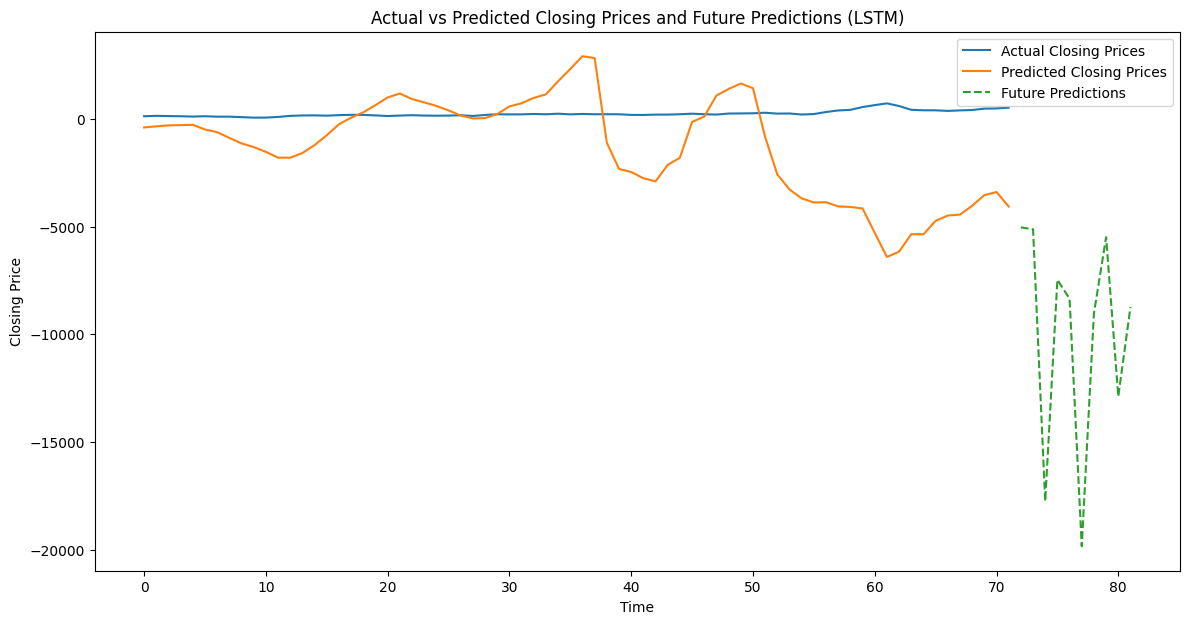

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(actual_closing_prices, label='Actual Closing Prices')
plt.plot(predicted_closing_prices, label='Predicted Closing Prices')
plt.plot(np.arange(len(actual_closing_prices), len(actual_closing_prices) + future_steps), future_predictions, label='Future Predictions', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices and Future Predictions (LSTM)')
plt.legend()
plt.show()

In [30]:
mse = mean_squared_error(actual_closing_prices, predicted_closing_prices)
mae = mean_absolute_error(actual_closing_prices, predicted_closing_prices)
r2 = r2_score(actual_closing_prices, predicted_closing_prices)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 7961123.786154787
MAE: 2108.685017347336
R-squared: -411.7185594143025
